In [1]:
import os
os.chdir("../src")
import glasgow_behavior
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, size):
            self.set_thetagrids(np.degrees(theta), labels, size=size)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(ax, d, title, theta, spoke_labels, thresholds=None, colors=None):
    ax.set_rgrids([])
    ax.set_title(title, size=13, position=(0.5, 1), y=1.15,
                    horizontalalignment='center', verticalalignment='center')
    #Zero line
    ax.plot(theta, np.zeros(len(d)), color='grey', lw=1.8)
    ax.plot(theta, d, color='black', lw=2.5)

    ax.set_varlabels(spoke_labels, 10.5)
    ax.set_ylim(-0.5,0.5)

    a = ax.get_xgridlines()

    if thresholds != None:
        if colors == None:
            print("WARNING: Threshold colors not supplied!")
            return ax
        i = 0
        ti = 0
        t = 0
        for line in a:
            if i > (t-1):
                t = thresholds[ti]
                c = colors[ti]
                ti += 1
            line.set_color(c) 
            i+=1
    return ax

def rain_plot(ax, df, cPalette, order, dx, dy, compute_stats=False, stat_start=[-5,24], stat_gap=1.8):

    ort = "h"; sigma = .5; cut=1.7; move=0.2; linewidth=2; 
    scale=0.85; pointplot=False

    ax=pt.RainCloud(x = dx, y = dy, data = df, palette = cPalette, bw = sigma, cut=cut, order=order, pointplot=pointplot,
                        width_viol = scale, ax = ax, orient = ort, move = move, scale="width", linewidth = linewidth, linecolor="red")

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines.bottom.set(linewidth=6)

    if compute_stats:
        #data without PTT
        stat_df = df[df[dx] != "PTT"]

        #compute stats
        comp1 = mc.MultiComparison(stat_df[dy], stat_df[dx])
        tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")

        #ANOVA
        all_data = []
        for group in order:
            all_data.append(stat_df[stat_df[dx] == group][dy].to_numpy())
        f, p = f_oneway(*all_data)

        ax.set_title(f'{dy}\n F={round(f,3)}, p={round(p,3)}')

        #stat bars
        #first row is column names

        loc = {}
        switch = False
        for row in tbl.data[1:]:
            if row[5]:
                g1 = row[0]
                g2 = row[1]
                if g1 == order[-1] or g2 == order[-1]:
                    right = False
                else:
                    right = True
                t = row[2]
                p = row[4]

                g1_i = order.index(g1)
                g2_i = order.index(g2)
                bottom = min(g1_i, g2_i)
                top = max(g1_i, g2_i)

                #length controls line plot x location
                length = abs(g2_i-g1_i)
                gap = stat_gap
                x_dist_iter = length
                x_dist = gap
                br_length =0.75
                

                while x_dist_iter -1 > 0:
                    x_dist_iter -=1
                    x_dist += x_dist_iter + gap

                if right:
                    x_pos = x_dist + stat_start[1] + ((top - length) %length)
                    br_length = -br_length
                    text_offset = 0.8
                else:
                    x_pos = -x_dist + stat_start[0] - ((top - length) %length)
                    text_offset = -2.3
                    
                y_offset = -move
                y_scale = 1
                y_gap = 0.09

                

                #vertical line
                ax.plot([x_pos, x_pos], [y_scale*bottom+y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                y_top = y_scale*top-y_gap + y_offset
                y_bottom = y_scale*bottom+y_gap + y_offset
                sig = "ERROR"
                if p < 0.05:
                    if p < 0.01:
                        if p < 0.001:
                            sig = "***"
                        else:
                            sig = "**"
                    else:
                        sig = "*"

                ax.text(x_pos + text_offset, y_bottom + (y_top-y_bottom)/2, sig,rotation=90, clip_on=False, backgroundcolor='white', zorder=2, color='black', va='center')
                #horizontal bars
                ax.plot([x_pos, x_pos+br_length], [y_scale*top-y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                ax.plot([x_pos, x_pos+br_length], [y_scale*bottom+y_gap + y_offset, y_scale*bottom+y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
    return ax

def correlation_plot(fig, ax, df):
    corr_data = df.to_numpy()
    i = 0
    for x in range(len(corr_data)):
        for y in range(len(corr_data)):
            if y > i:
                corr_data[x][y] = 0
        i += 1

    im = ax.imshow(corr_data, cmap="bwr")
    im.set_clim(-1,1)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #BACS-CAARMS lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+8], [ax.get_ylim()[1]+8, ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+8, ax.get_xlim()[0]+8], [ax.get_ylim()[0], ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)

    #CAARMS-SPIA lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+13], [ax.get_ylim()[1]+13, ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+13, ax.get_xlim()[0]+13], [ax.get_ylim()[0], ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)

    #Legend bars y axis
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]), 1,8, facecolor = 'fuchsia', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+8), 1,5.1, facecolor = 'forestgreen', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+13.1), 1,14, facecolor = 'orange', clip_on=False))

    #Legend bars x axis
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[0]), 8,1, facecolor = '#FF00FF', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+8, ax.get_ylim()[0]), 5.1,1, facecolor = '#176423', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+13.1, ax.get_ylim()[0]), 14,1, facecolor = '#ff9402', clip_on=False))

    #Hide the diagonal data
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[1]-1.5), 40,1, facecolor = 'white', angle=45, clip_on=False))

    legend_elements = [Patch(facecolor='#FF00FF', label='BACS (1-8)'),
                    Patch(facecolor='#176423', label='CAARMS (9-13)'),
                    Patch(facecolor='#ff9402', label='SPIA (14-27)')]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1.05,1), frameon=False)
    plt.colorbar(im, ax=ax, shrink=0.28, aspect=7, pad=-0.15)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Cannot load file /Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii with sulcal depth data


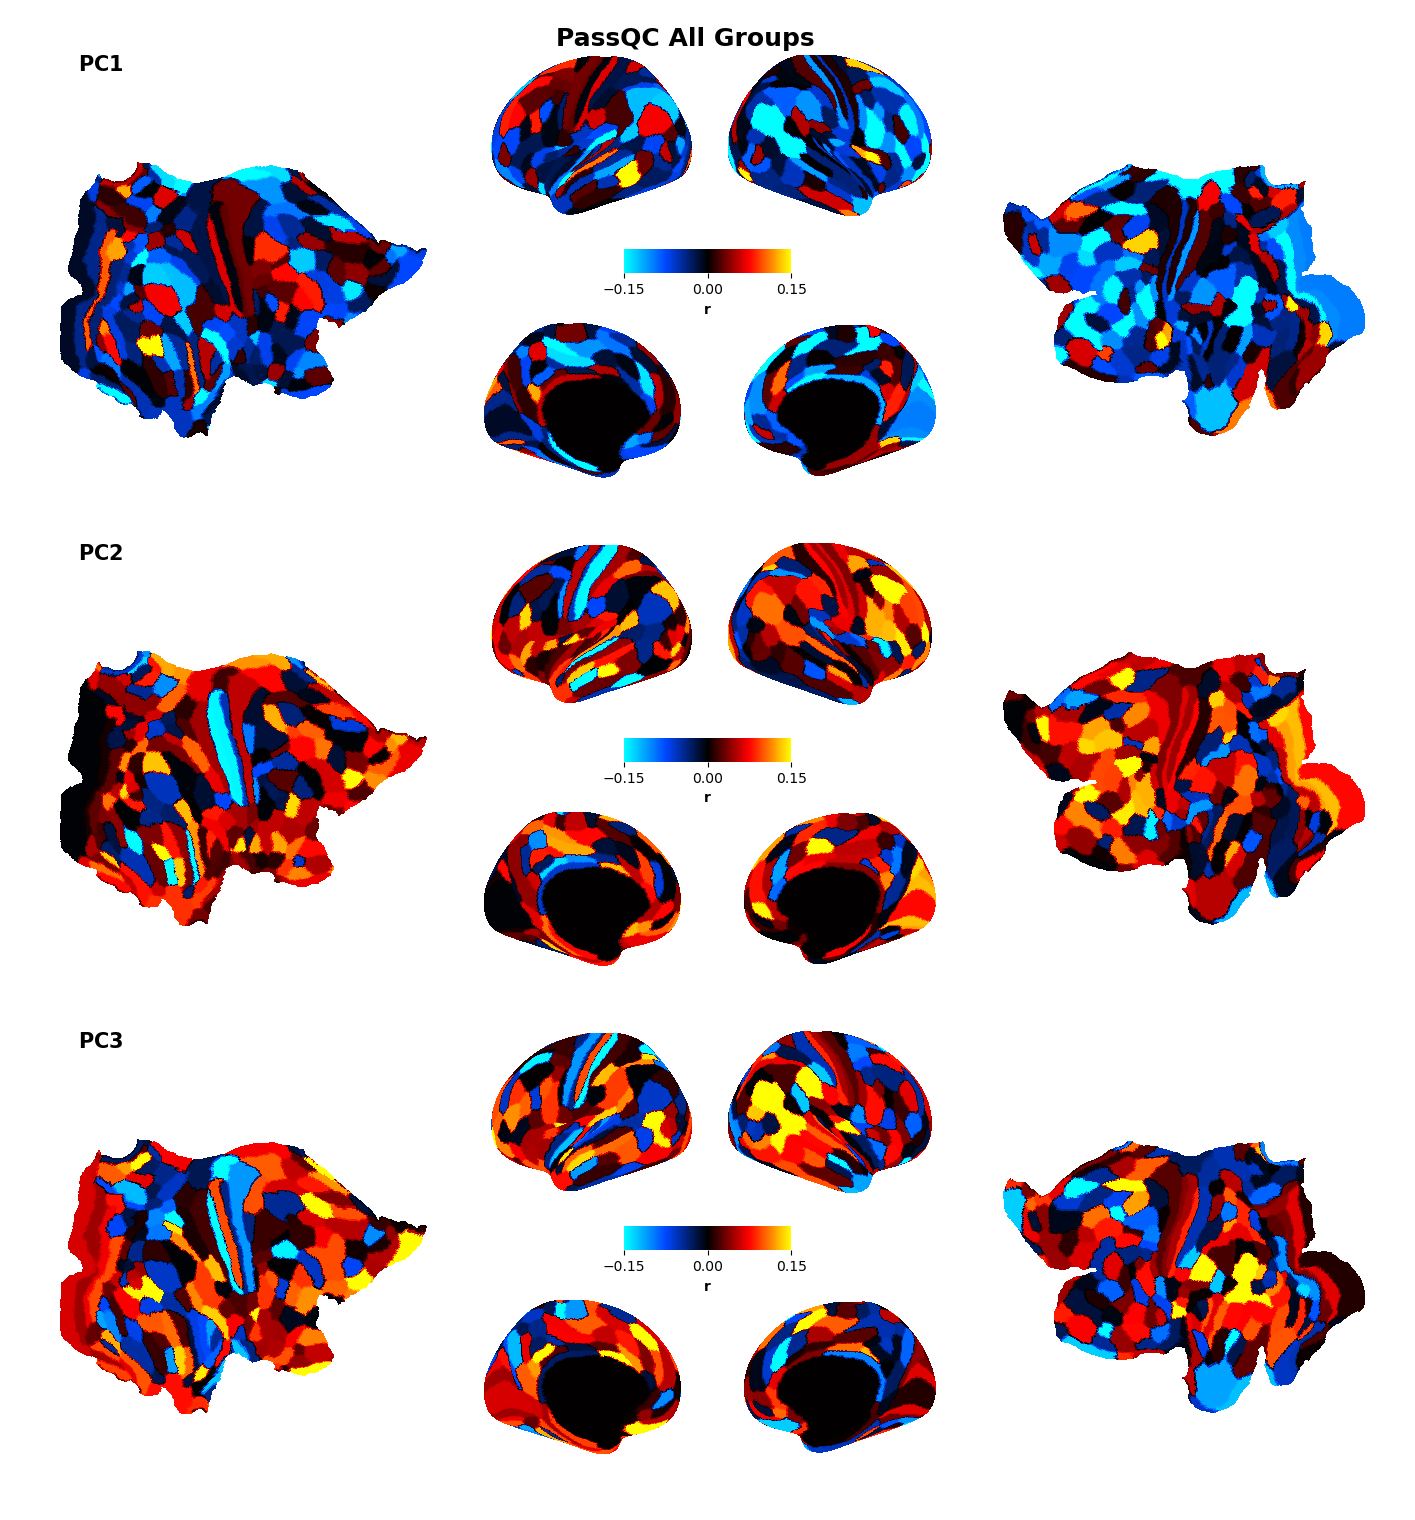

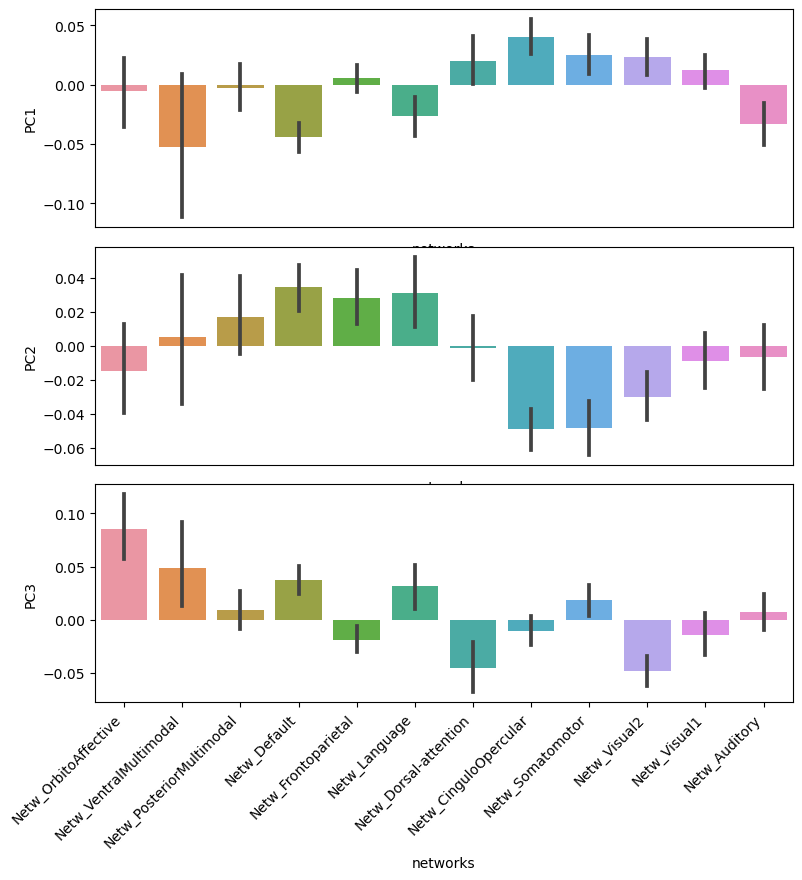

In [2]:
import os
import nibabel as nib
import nilearn.plotting as plotting
import hcp_utils as hcp
import matplotlib as mpl
import seaborn as sns


def neural_plots(mesh_file, neural_data, geom_data, title, subtitles, reverse=False):
    if type(neural_data) != list:
        neural_data = [neural_data]
    num_files = len(neural_data)
    fig = plt.figure(figsize=(18,num_files*9))
    #heights = [1,0.75,0.4,0.8]
    widths = [0.9,0.9,1,1,0.9,0.9]
    spec = fig.add_gridspec(ncols=6,nrows=num_files*2, width_ratios=widths)
    #spec = fig.add_gridspec(ncols=5,nrows=4,height_ratios=heights)
    fig.subplots_adjust(wspace=-0.04, hspace=-0.74, top=0.85, bottom=0.05)
    fig.suptitle(title, size=18, weight='bold', y=(0.41+(num_files*0.05)))
    # 0.57
    fig_geom = plt.figure(figsize=(9,num_files*3))
    spec_geom = fig_geom.add_gridspec(ncols=6,nrows=num_files*2)

    mesh = hcp.load_surfaces(example_filename=mesh_file)


    row=0
    for neural_file, geom_file, subtitle in zip(neural_data, geom_data, subtitles):
        #all possible views
        #vDict = {'lateral':0,'medial':1,'anterior':2,'posterior':3,'dorsal':4,'ventral':5}
        vDict = {'lateral':0,'medial':1}


        img = nib.load(neural_file)
        n_data = img.get_fdata()
        if reverse:
            n_data = n_data * -1

        vmin=-0.15
        vmax=0.15
        c256=["#00ffff","#00fdff","#00faff","#00f7ff","#00f4ff","#00f1ff","#00eeff","#00ebff","#00e9ff","#00e6ff","#00e3ff","#00e0ff","#00ddff","#00daff","#00d7ff","#00d4ff","#00d1ff","#00ceff","#00cbff","#00c9ff","#00c6ff","#00c3ff","#00c0ff","#00bdff","#00baff","#00b7ff","#00b4ff","#00b1ff","#00aeff","#00abff","#00a9ff","#00a6ff","#00a3ff","#00a0ff","#009dff","#009aff","#0097ff","#0094ff","#0091ff","#008eff","#008bff","#0088ff","#0086ff","#0083ff","#0080ff","#007dff","#007aff","#0077ff","#0074ff","#0071ff","#006eff","#006bff","#0069ff","#0066ff","#0063ff","#0060ff","#005dff","#005aff","#0057ff","#0054ff","#0051ff","#004eff","#004bff","#0048ff","#0046ff","#0045fb","#0044f7","#0043f3","#0042ef","#0041eb","#003fe7","#003ee3","#003ddf","#003cdb","#003bd7","#003ad3","#0039cf","#0038cb","#0037c7","#0035c3","#0034bf","#0033bb","#0032b7","#0031b3","#0030af","#002fab","#002ea7","#002da2","#002c9e","#002a9a","#002996","#002892","#00278e","#00268a","#002586","#002482","#00237e","#00227a","#002176","#001f72","#001e6e","#001d6a","#001c66","#001b62","#001a5e","#00195a","#001856","#001752","#00164e","#00144a","#001346","#001242","#00113e","#00103a","#000f36","#000e32","#000d2e","#000c2a","#000a26","#000922","#00081e","#00071a","#000616","#000512","#00040e","#00030a","#000206","#000102","#020000","#060000","#0a0000","#0e0000","#120000","#160000","#1a0000","#1e0000","#220000","#260000","#2a0000","#2e0000","#320000","#360000","#3a0000","#3e0000","#420000","#460000","#4a0000","#4e0000","#520000","#560000","#5a0000","#5e0000","#620000","#660000","#6a0000","#6e0000","#720000","#760000","#7a0000","#7e0000","#820000","#860000","#8a0000","#8e0000","#920000","#960000","#9a0000","#9e0000","#a20000","#a70000","#ab0000","#af0000","#b30000","#b70000","#bb0000","#bf0000","#c30000","#c70000","#cb0000","#cf0000","#d30000","#d70000","#db0000","#df0000","#e30000","#e70000","#eb0000","#ef0000","#f30000","#f70000","#fb0000","#ff0000","#ff0300","#ff0700","#ff0b00","#ff0f00","#ff1300","#ff1700","#ff1b00","#ff1f00","#ff2300","#ff2700","#ff2b00","#ff2f00","#ff3300","#ff3700","#ff3b00","#ff3f00","#ff4300","#ff4700","#ff4b00","#ff4f00","#ff5300","#ff5700","#ff5b00","#ff5f00","#ff6300","#ff6700","#ff6b00","#ff6f00","#ff7300","#ff7700","#ff7b00","#ff7f00","#ff8300","#ff8700","#ff8b00","#ff8f00","#ff9300","#ff9700","#ff9b00","#ff9f00","#ffa300","#ffa800","#ffac00","#ffb000","#ffb400","#ffb800","#ffbc00","#ffc000","#ffc400","#ffc800","#ffcc00","#ffd000","#ffd400","#ffd800","#ffdc00","#ffe000","#ffe400","#ffe800","#ffec00","#fff000","#fff400","#fff800","#fffc00","#ffff00"]
        cmap = mpl.colors.ListedColormap(c256)

        if '.pscalar.nii' in neural_file:
            plot_data = hcp.unparcellate(n_data[0], hcp.ca_parcels)
        else:
            plot_data = n_data

        c_data_left = hcp.left_cortex_data(plot_data)
        c_data_right = hcp.right_cortex_data(plot_data)

        axes = []
        for view in vDict.keys():
            ax_left = fig.add_subplot(spec[row+vDict[view],2], projection='3d')
            ax_right = fig.add_subplot(spec[row+vDict[view],3], projection='3d')
            axes.append(ax_left)
            axes.append(ax_right)
            
            

            plotting.plot_surf(mesh.very_inflated_left, surf_map=c_data_left, engine='matplotlib',view=view, figure=fig, 
                            axes=ax_left, hemi='left', vmin=vmin, vmax=vmax, cmap=cmap)
            #ax_left.view_init(azim=180)
            
            plotting.plot_surf(mesh.very_inflated_right, c_data_right, engine='matplotlib',view=view, figure=fig, 
                            axes=ax_right, hemi='right', vmin=vmin, vmax=vmax, cmap=cmap)
            
            #ax_left.set_facecolor('black')
            #ax_right.set_facecolor('black')

        ax_flat_left = fig.add_subplot(spec[row+0:row+2,0:2], projection='3d')
        ax_flat_right = fig.add_subplot(spec[row+0:row+2,4:6], projection='3d')
        axes.append(ax_flat_left)
        axes.append(ax_flat_right)
        plotting.plot_surf(mesh.flat_left, surf_map=c_data_left, engine='matplotlib', figure=fig, 
                            axes=ax_flat_left, hemi='left', vmin=vmin, vmax=vmax, cmap=cmap)
        plotting.plot_surf(mesh.flat_right, surf_map=c_data_right, engine='matplotlib', figure=fig, 
                            axes=ax_flat_right, hemi='left', vmin=vmin, vmax=vmax, cmap=cmap)

        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, shrink=0.12, aspect=7, pad=-0.24, orientation='horizontal',
                    ticks=[-0.15,0,0.15], label=fr"$\bf{{r}}$", drawedges=False)
        
        cb.outline.set_visible(False)

        ax_flat_left.set_title(subtitle, size=15, x=0.2)

        ax_geom = fig_geom.add_subplot(spec_geom[row:row+2,:])
        geom_df = pd.read_csv(geom_file)
        order_geom = ["Netw_OrbitoAffective", "Netw_VentralMultimodal", "Netw_PosteriorMultimodal", "Netw_Default", "Netw_Frontoparietal", "Netw_Language", "Netw_Dorsal-attention", "Netw_CinguloOpercular", "Netw_Somatomotor", "Netw_Visual2", "Netw_Visual1", "Netw_Auditory"]
        sns.barplot(data=geom_df, x='networks', y=geom_df.columns[0], order=order_geom, ax=ax_geom)
        if row == ((num_files-1)*2):
            ax_geom.set_xticks(ax_geom.get_xticks(), ax_geom.get_xticklabels(), rotation=45, ha='right')
        else:
            ax_geom.set(xticklabels=[])
            ax_geom.tick_params(bottom=False)
        
        
        row+=2
    fig_geom.savefig(f'{title.replace(" ","_")}_geometry.png')
    #fig.show()
    plt.show()
#template_path = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
mesh_data = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
data_format = '/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_ALL1.pscalar.nii'
pcs = 3
group = 'ALL'
neural_data = []
geom_data = []
subtitles = []
for pc in range(pcs):
    neural_data.append(f'/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_{group}{pc+1}.pscalar.nii')
    subtitles.append(fr'$\bf{{PC{pc+1}}}$')
    geom_data.append(f'/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_PassQC_CBS_NT_n176/analysis/results/geometry/PC{pc+1}_network_NT_n176_{group}.csv')
neural_plots(mesh_data, neural_data, geom_data, 'PassQC All Groups', subtitles, True)

Cannot load file /Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii with sulcal depth data


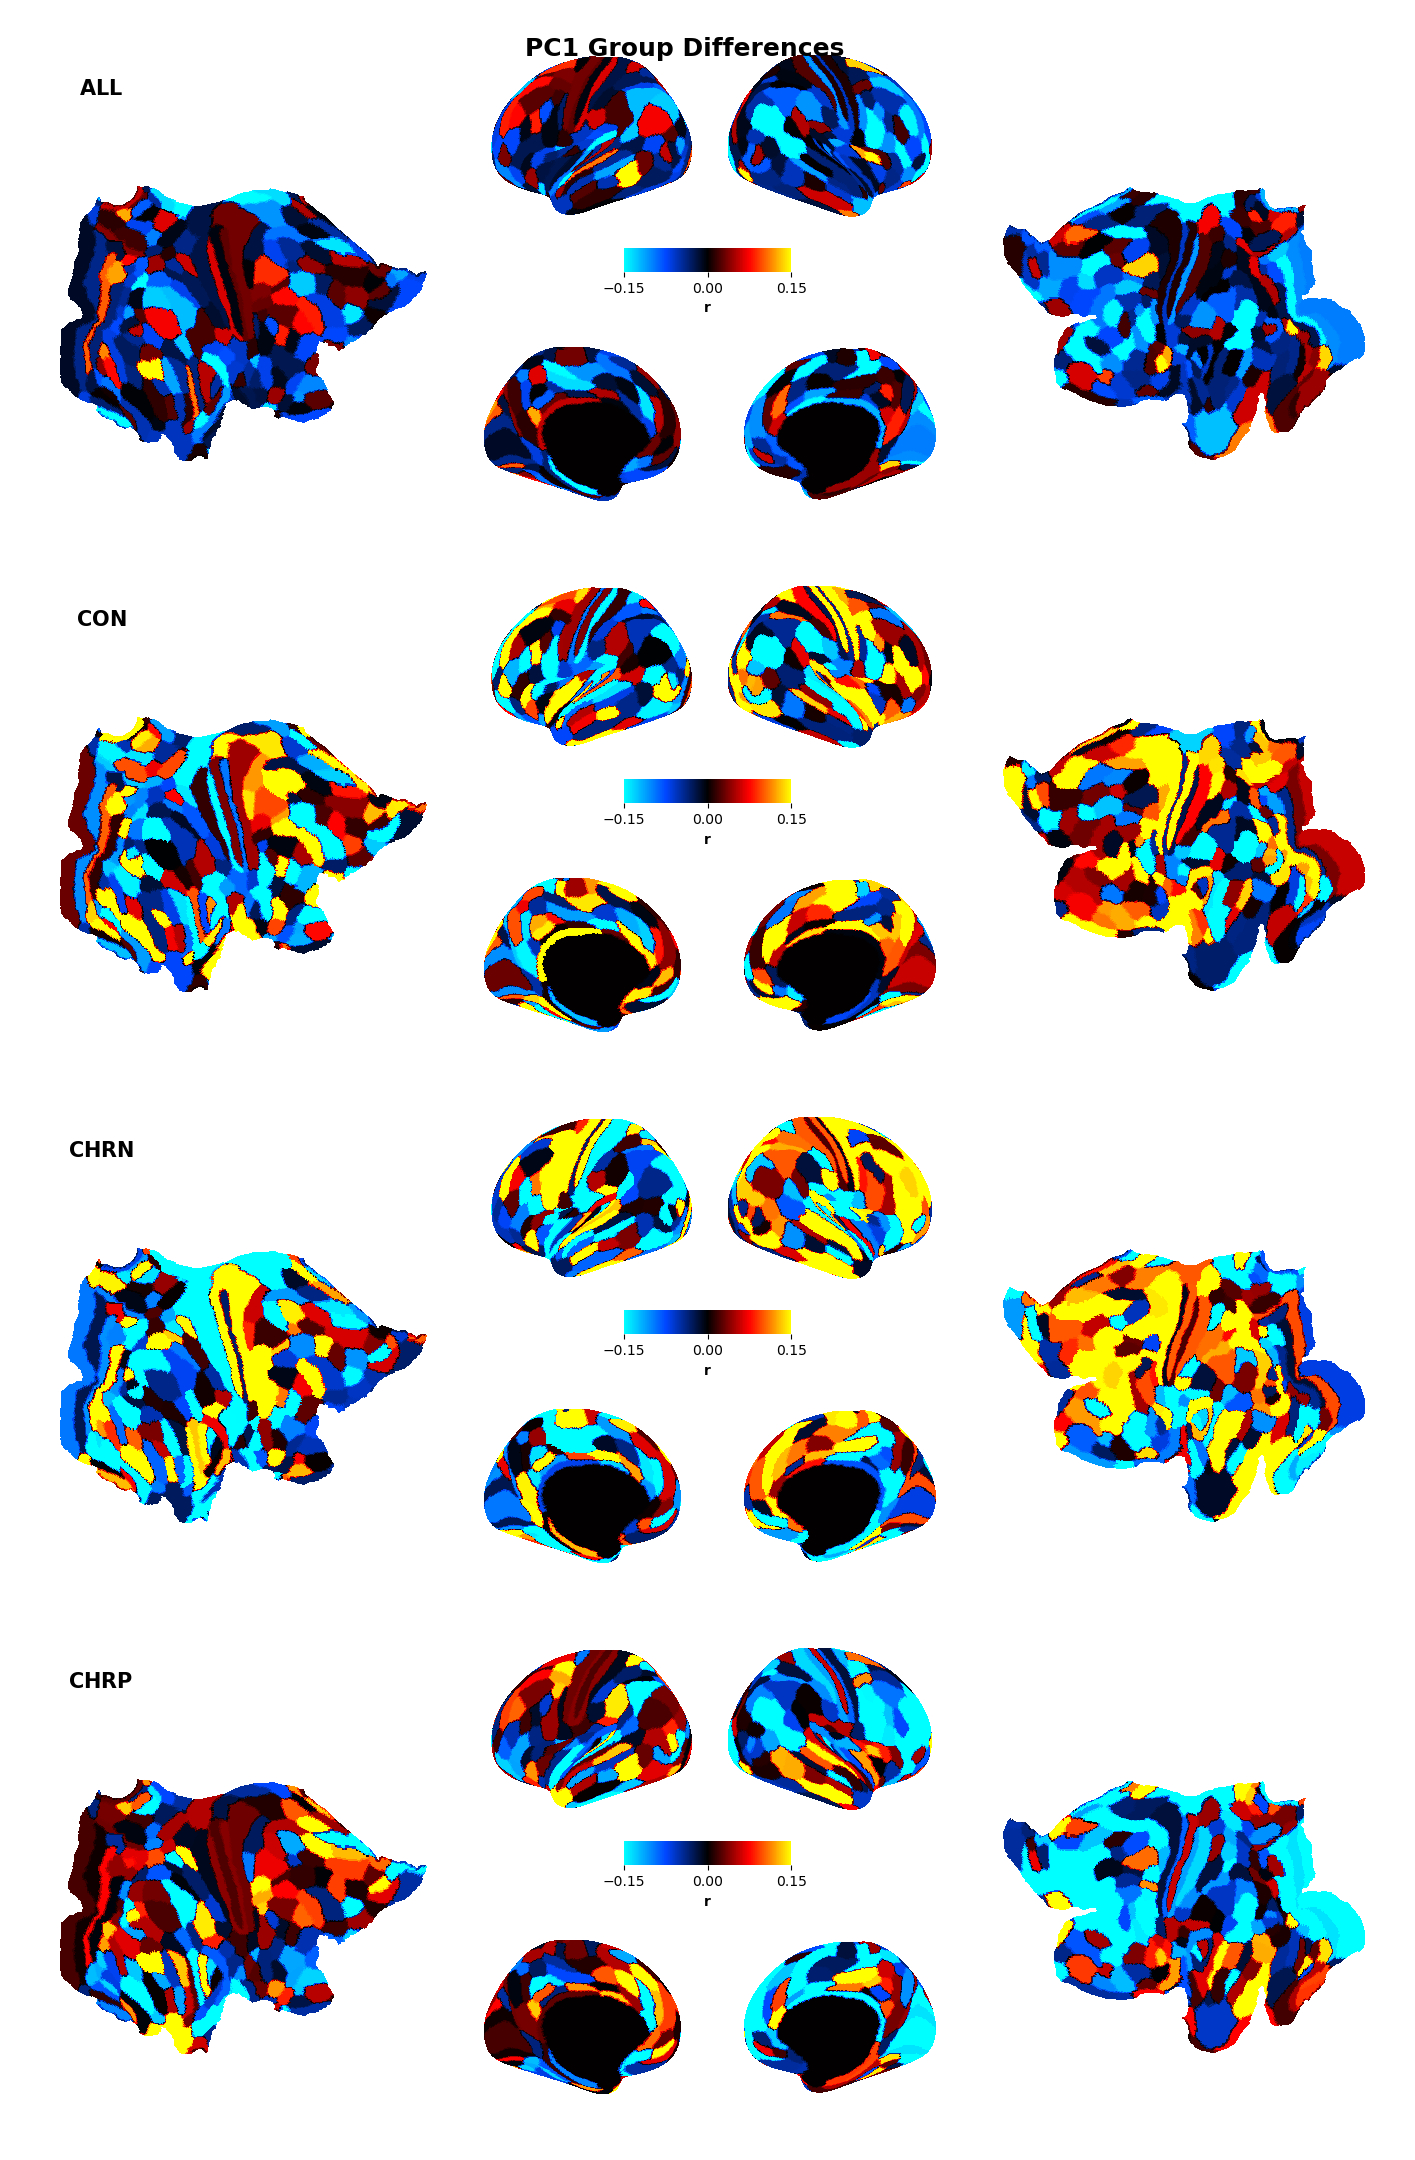

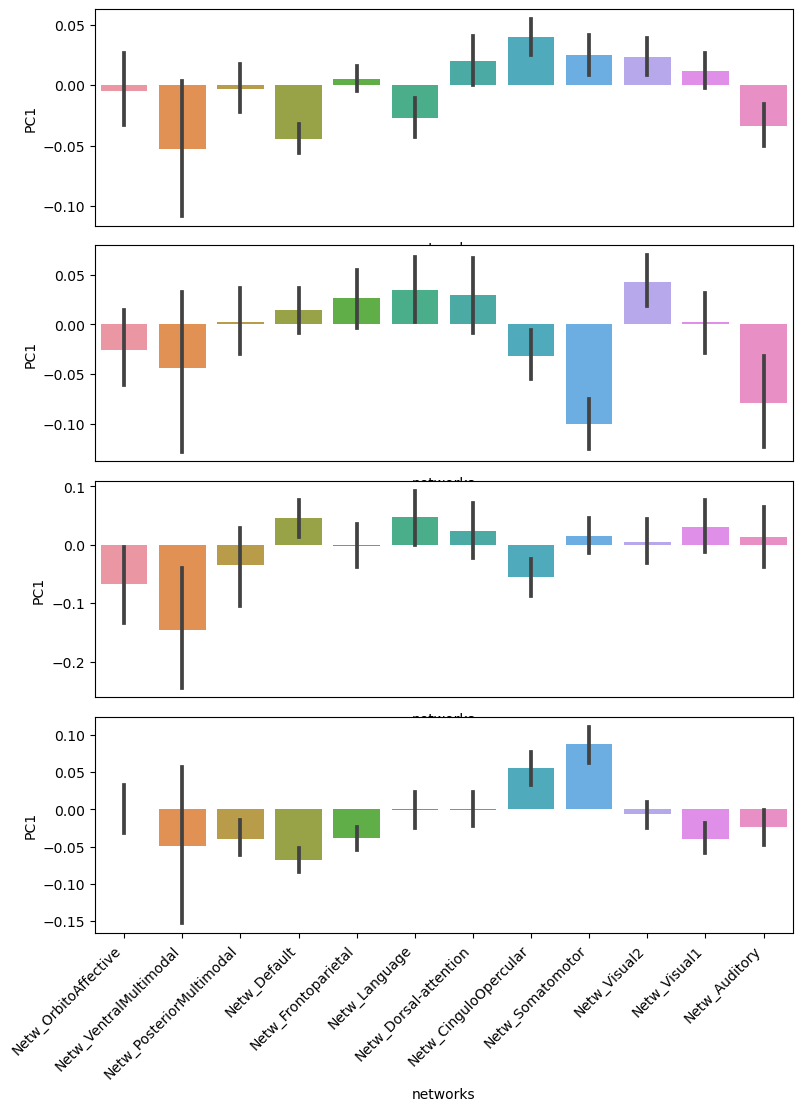

In [ ]:
mesh_data = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
#data_format = '/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_ALL1.pscalar.nii'
pcs = 3
groups = ['ALL','CON','CHRN','CHRP']
neural_data = []
geom_data = []
subtitles = []
for group in groups:
    neural_data.append(f'/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_{group}1.pscalar.nii')
    subtitles.append(fr'$\bf{{{group}}}$')
    geom_data.append(f'/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_PassQC_CBS_NT_n176/analysis/results/geometry/PC1_network_NT_n176_{group}.csv')
neural_plots(mesh_data, neural_data, geom_data, 'PC1 Group Differences', subtitles, True)

In [ ]:
mesh_data = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
#data_format = '/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_ALL1.pscalar.nii'
pcs = 3
groups = ['ALL','CON','CHRN','CHRP']
neural_data = []
geom_data = []
subtitles = []
for group in groups:
    neural_data.append(f'/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_{group}1.pscalar.nii')
    subtitles.append(fr'$\bf{{{group}}}$')
    geom_data.append(f'/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_PassQC_CBS_NT_n176/analysis/results/geometry/PC1_network_NT_n176_{group}.csv')
neural_plots(mesh_data, neural_data, geom_data, 'PC1 Group Differences', subtitles, True)

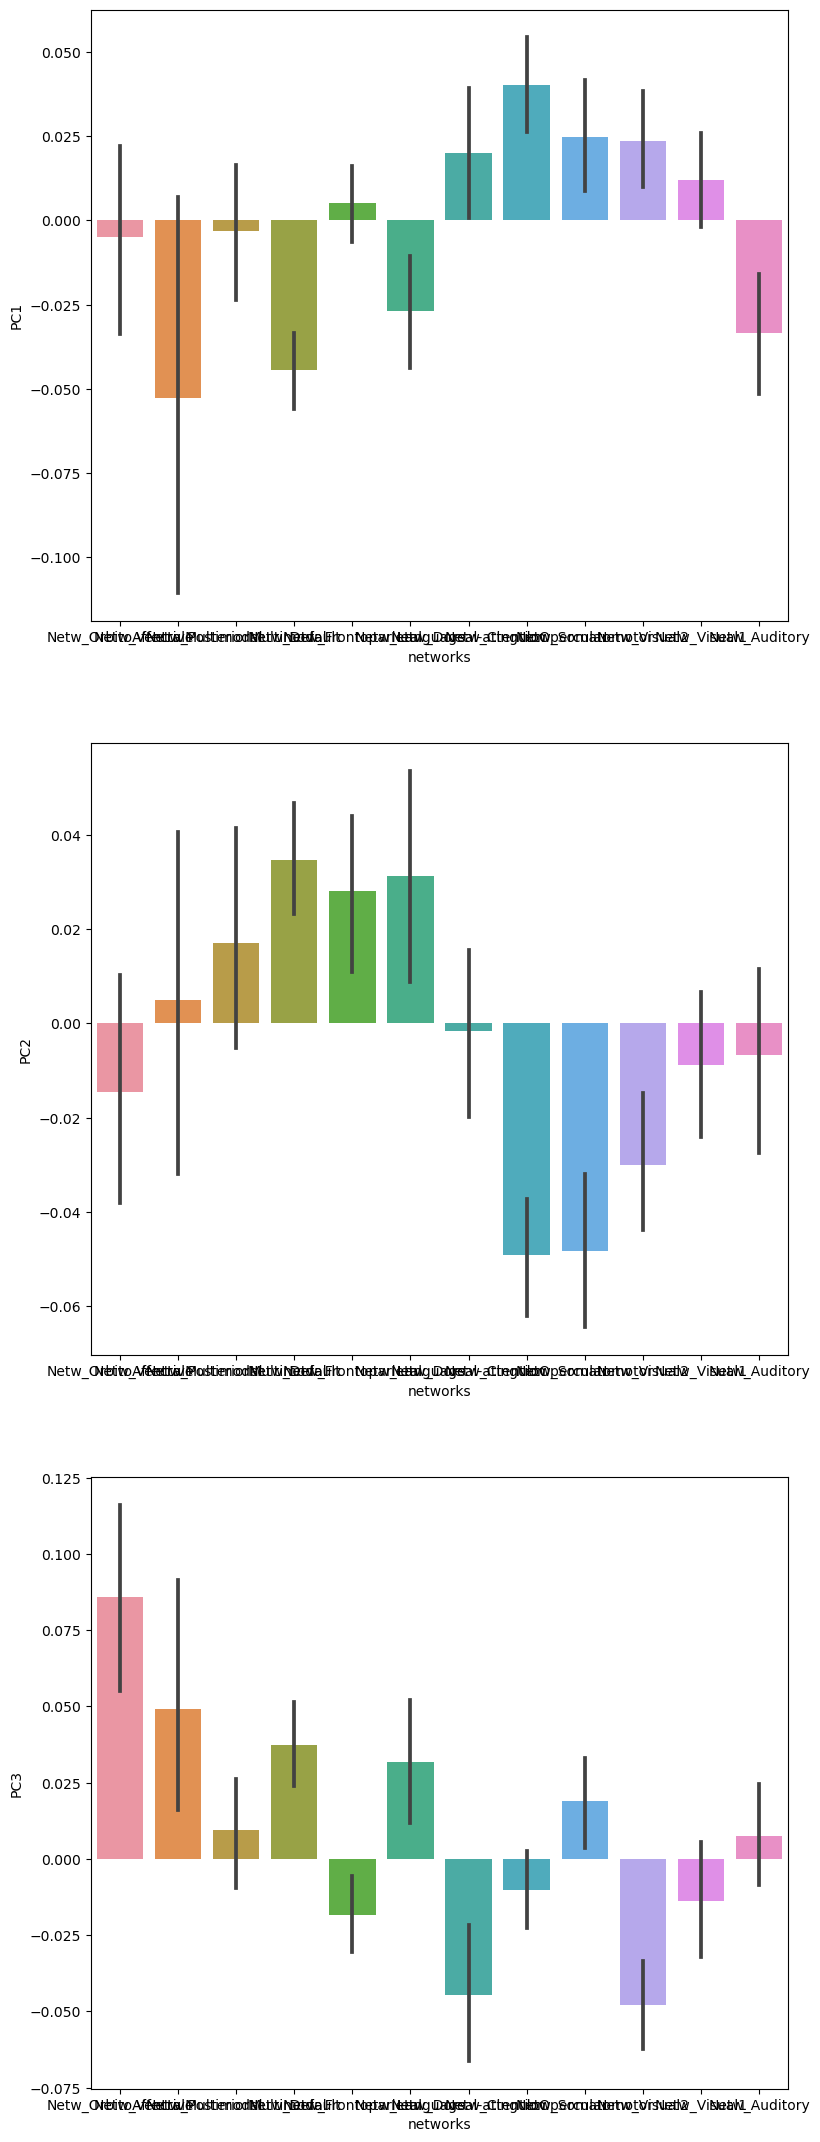

In [ ]:
num_files=3
fig_geom = plt.figure(figsize=(9,num_files*9))
spec_geom = fig_geom.add_gridspec(ncols=2,nrows=3)
row=0
for geom_file in geom_data:
    ax_geom = fig_geom.add_subplot(spec_geom[row,0:2])
    geom_df = pd.read_csv(geom_file)
    order_geom = ["Netw_OrbitoAffective", "Netw_VentralMultimodal", "Netw_PosteriorMultimodal", "Netw_Default", "Netw_Frontoparietal", "Netw_Language", "Netw_Dorsal-attention", "Netw_CinguloOpercular", "Netw_Somatomotor", "Netw_Visual2", "Netw_Visual1", "Netw_Auditory"]
    sns.barplot(data=geom_df, x='networks', y=geom_df.columns[0], order=order_geom, ax=ax_geom)
    row+=1